In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn.functional as F
from torchvision import transforms, utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from unet.unet_helpers import MicroscopeImageDataset, ToTensor
from unet.unet import UNet

In [3]:
etching_dataset = MicroscopeImageDataset(img_dir='./images/etching/', mask_dir='./images/etching/masks/',
                                         transform=ToTensor(), 
                                        split_samples=(4,4))

In [ ]:
# Show the samples
fig = plt.figure(figsize=(20,13))

for i in range(len(etching_dataset)):
    sample = etching_dataset[i]
    image, mask = sample['image'], sample['mask']

    print(i, image.shape, mask.shape)

    ax = plt.subplot(10, 2, 2*i + 1)
    plt.tight_layout()
    plt.imshow(image[0,:,:], cmap='gray', vmin=0, vmax=255)
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    
    ax = plt.subplot(10, 2, 2*i + 2)
    plt.tight_layout()
    plt.imshow(mask, cmap='gray', vmin=0, vmax=1)
    ax.set_title('Sample #{} mask'.format(i))
    ax.axis('off')


    if i == 9:
        plt.show()
        break

In [4]:
# Train parameter
epochs = 15
eta = 1e-3
lambda_l2 = 1e-3

# U-Net definition
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(n_classes=2, depth=3, wf=3, padding=True, up_mode='upsample').to(device)
optim = torch.optim.Adam(model.parameters(), lr=eta)
criterion = torch.nn.CrossEntropyLoss()
dataloader = DataLoader(etching_dataset, batch_size=4,
                        shuffle=True, num_workers=4)

avg_epoch_loss = []
for _ in range(epochs):
    print("Epoch {0}".format(_))
    loss_accum = 0
    for smple in dataloader:
        X = smple['image'].to(device)  # [N, 1, H, W]
        y = smple['mask'].to(device)  # [N, H, W] with class indices (0, 1)
        
        mu, std = X.mean(), X.std()
        X.sub_(mu).div_(std)
        
        prediction = model(X)  # [N, 2, H, W]
        loss = criterion(prediction, y)
        #L2 penalty
        for p in model.parameters():
            loss += lambda_l2 * p.pow(2).sum()
        print("Cross entropy loss: {:.02f}".format(loss.item()))
        loss_accum += loss.item()
        
        optim.zero_grad()
        loss.backward()
        optim.step()
    avg_epoch_loss.append(loss_accum/len(dataloader))


Epoch 0


C:\Users\silus\Anaconda3\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
C:\Users\silus\Anaconda3\lib\site-packages\torch\nn\functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Cross entropy loss: 0.74
Cross entropy loss: 0.74
Cross entropy loss: 0.74
Cross entropy loss: 0.75
Cross entropy loss: 0.69
Cross entropy loss: 0.75
Cross entropy loss: 0.71
Cross entropy loss: 0.68
Cross entropy loss: 0.69
Cross entropy loss: 0.70
Cross entropy loss: 0.69
Cross entropy loss: 0.69
Cross entropy loss: 0.69
Cross entropy loss: 0.70
Cross entropy loss: 0.70
Cross entropy loss: 0.77
Cross entropy loss: 0.69
Cross entropy loss: 0.66
Cross entropy loss: 0.68
Cross entropy loss: 0.70
Cross entropy loss: 0.65
Cross entropy loss: 0.65
Cross entropy loss: 0.65
Cross entropy loss: 0.64
Epoch 1
Cross entropy loss: 0.65
Cross entropy loss: 0.62
Cross entropy loss: 0.62
Cross entropy loss: 0.61
Cross entropy loss: 0.65
Cross entropy loss: 0.60
Cross entropy loss: 0.58
Cross entropy loss: 0.61
Cross entropy loss: 0.66
Cross entropy loss: 0.59
Cross entropy loss: 0.54
Cross entropy loss: 0.56
Cross entropy loss: 0.59
Cross entropy loss: 0.52
Cross entropy loss: 0.54
Cross entropy los

Cross entropy loss: 3.43
Cross entropy loss: 0.27
Cross entropy loss: 0.33
Cross entropy loss: 0.23
Cross entropy loss: 0.31
Cross entropy loss: 0.34
Cross entropy loss: 0.34
Cross entropy loss: 0.30
Cross entropy loss: 0.39
Cross entropy loss: 0.41
Cross entropy loss: 0.41
Cross entropy loss: 0.33
Epoch 14
Cross entropy loss: 0.32
Cross entropy loss: 0.27
Cross entropy loss: 0.31
Cross entropy loss: 0.36
Cross entropy loss: 0.31
Cross entropy loss: 0.43
Cross entropy loss: 0.38
Cross entropy loss: 0.41
Cross entropy loss: 0.37
Cross entropy loss: 0.39
Cross entropy loss: 0.29
Cross entropy loss: 0.34
Cross entropy loss: 0.37
Cross entropy loss: 0.26
Cross entropy loss: 0.33
Cross entropy loss: 0.26
Cross entropy loss: 0.25
Cross entropy loss: 0.24
Cross entropy loss: 0.25
Cross entropy loss: 0.21
Cross entropy loss: 0.24
Cross entropy loss: 0.27
Cross entropy loss: 0.19
Cross entropy loss: 0.21


Text(0, 0.5, 'CrossEntropyLoss')

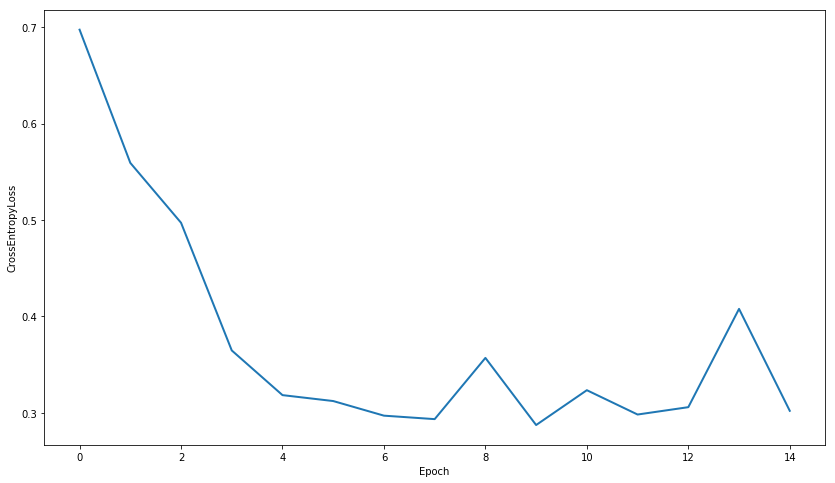

In [5]:
# Visualize
import numpy as np
fig, ax = plt.subplots(figsize=(14,8))
ax.plot(np.arange(epochs), np.array(avg_epoch_loss), linewidth=2)
ax.set_xlabel("Epoch")
ax.set_ylabel("CrossEntropyLoss")

0 torch.Size([1, 320, 240]) torch.Size([320, 240])


C:\Users\silus\Anaconda3\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
C:\Users\silus\Anaconda3\lib\site-packages\torch\nn\functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
C:\Users\silus\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


1 torch.Size([1, 320, 240]) torch.Size([320, 240])
2 torch.Size([1, 320, 240]) torch.Size([320, 240])
3 torch.Size([1, 320, 240]) torch.Size([320, 240])
4 torch.Size([1, 320, 240]) torch.Size([320, 240])


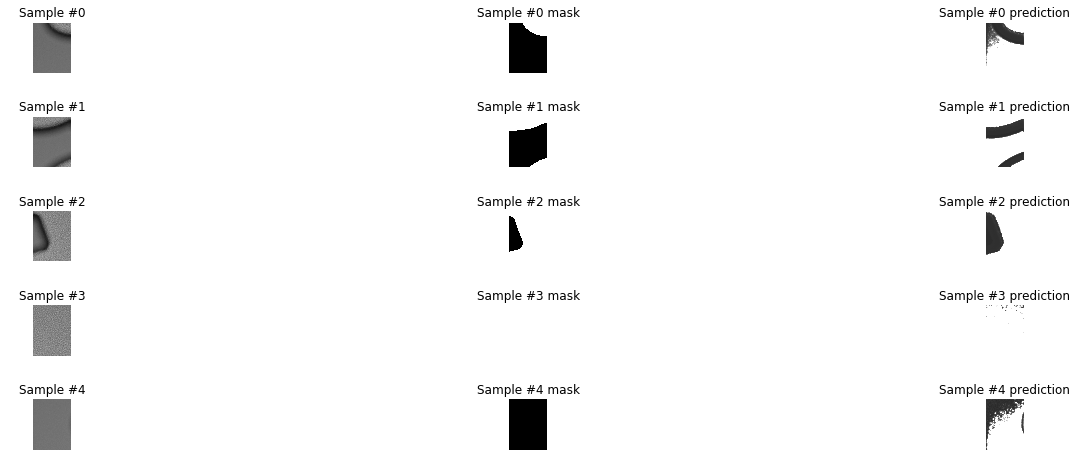

In [11]:
inspect_dataset = MicroscopeImageDataset(img_dir='./images/etching/test/', mask_dir='./images/etching/masks/',
                                         transform=ToTensor(), 
                                        split_samples=(4,4))

fig = plt.figure(figsize=(20,13))
for i in range(len(inspect_dataset)):
    sample = inspect_dataset[i]
    image, mask = sample['image'], sample['mask']

    print(i, image.shape, mask.shape)

    ax = plt.subplot(10, 3, 3*i + 1)
    plt.imshow(image[0,:,:], cmap='gray', vmin=0, vmax=255)
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    
    ax = plt.subplot(10, 3, 3*i + 2)
    plt.imshow(mask, cmap='gray', vmin=0, vmax=1)
    ax.set_title('Sample #{} mask'.format(i))
    ax.axis('off')

    ax = plt.subplot(10, 3, 3*i + 3)
    with torch.no_grad():
        x = image[None,:,:,:]
        mean, std = x.mean(), x.std()
        x.sub_(mean).div_(std)
        y = F.log_softmax(model(x))
        img = y[0,:,:,:]
        plt.imshow(-img[0,:,:], cmap='gray', vmin=0, vmax=1)
    ax.set_title('Sample #{} prediction'.format(i))
    ax.axis('off')

    plt.tight_layout()
    if i == 4:
        plt.show()
        break
    